In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
register_matplotlib_converters()

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [3]:
load_df = pd.read_csv('Data/DOM/Load Actuals/Processed/Aggregated/load.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
load_df

C:\Users\Ali\AppData\Local\Temp\ipykernel_16828\888559681.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  load_df = pd.read_csv('Data/DOM/Load Actuals/Processed/Aggregated/load.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


DATE
2010-01-01 00:00:00    10273.0
2010-01-01 01:00:00     9960.0
2010-01-01 02:00:00     9797.0
2010-01-01 03:00:00     9715.0
2010-01-01 04:00:00     9851.0
                        ...   
2019-12-31 19:00:00    11682.0
2019-12-31 20:00:00    11443.0
2019-12-31 21:00:00    11167.0
2019-12-31 22:00:00    10839.0
2019-12-31 23:00:00    10593.0
Name: MW, Length: 87648, dtype: float64

In [4]:
load_df = load_df.asfreq(pd.infer_freq(load_df.index))

In [5]:
start_date = datetime(2017,1,1)
end_date = datetime(2019,1,1)
lim_load_df = load_df[start_date:end_date]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

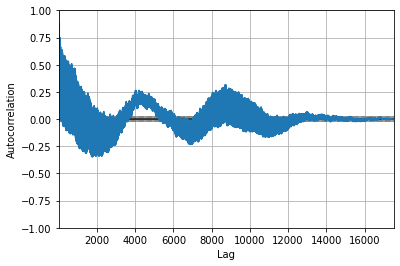

In [8]:
autocorrelation_plot(lim_load_df)

In [6]:
def plot_trend(data):
    plt.figure(figsize=(12,4))
    plt.plot(data)
    plt.title('Hourly Load Data', fontsize=20)
    plt.ylabel('Load', fontsize=16)
    for year in range(start_date.year,end_date.year):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

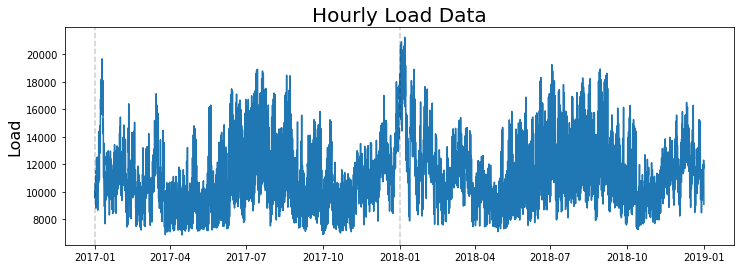

In [7]:
plot_trend(lim_load_df)

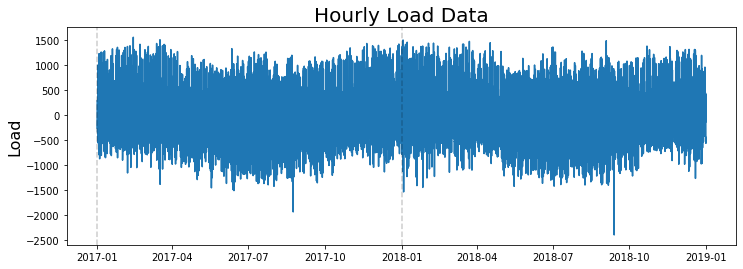

In [11]:
first_diff = lim_load_df.diff()[1:]
plot_trend(first_diff)

<BarContainer object of 20 artists>

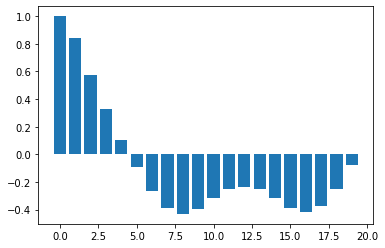

In [12]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

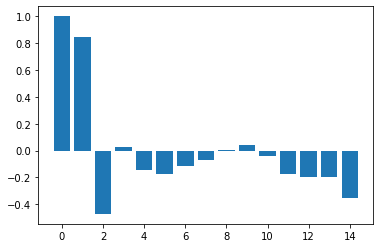

In [13]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [14]:
train_end = datetime(2018, 7, 1)
test_end = datetime(2019, 1, 1)

train_data = lim_load_df[:train_end]
test_data = lim_load_df[train_end + timedelta(days=1):test_end]

In [102]:
model = ARIMA(train_data, order=(24, 0, 0))
model_fit = model.fit()

In [103]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     MW   No. Observations:                13105
Model:                ARIMA(24, 0, 0)   Log Likelihood              -86200.941
Date:                Fri, 08 Apr 2022   AIC                         172453.882
Time:                        23:53:54   BIC                         172648.381
Sample:                    01-01-2017   HQIC                        172518.844
                         - 07-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.121e+04    244.200     45.904      0.000    1.07e+04    1.17e+04
ar.L1          1.8106      0.005    357.225      0.000       1.801       1.820
ar.L2         -1.1535      0.011   -107.594      0.0

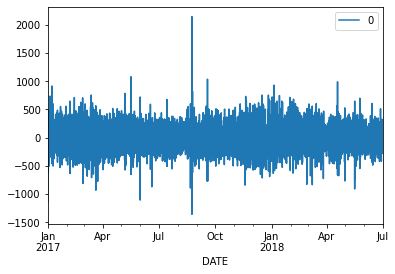

In [104]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

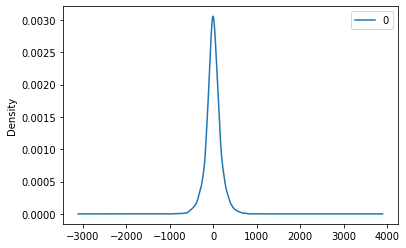

In [105]:
residuals.plot(kind='kde')
plt.show()

In [106]:
print(residuals.describe())

                  0
count  13105.000000
mean       0.034211
std      174.192037
min    -1360.227275
25%      -91.746550
50%       -1.698588
75%       90.862867
max     2143.592658


In [107]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [108]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

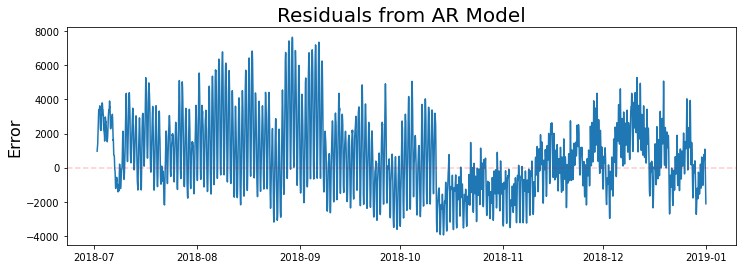

In [109]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

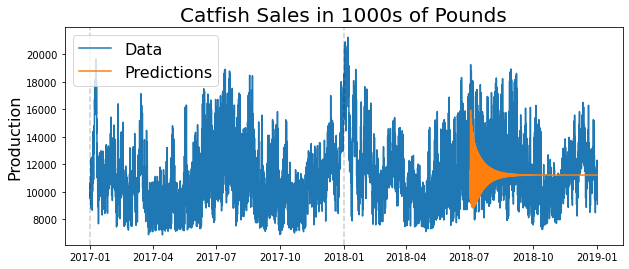

In [110]:
plt.figure(figsize=(10,4))

plt.plot(lim_load_df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [111]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1443


In [112]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2262.075537404449
